In [1]:
import cv2
from utils import stabilize, subtract_background, morphological_segmentation, circularity_filter, eccentricity_filter, size_filter, optic_flow_scores
import matplotlib.pyplot as plt
import numpy as np
VIDEOS_DIR = './videos'

In [12]:
cap = cv2.VideoCapture(VIDEOS_DIR + '/rally1.mp4')

# get first frame
ret, prev = cap.read()

# convert frame to grayscale
prev_gray = cv2.resize(cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY),(1300,500))

# create an ellipsoidal structuring element with a size of (5, 5)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)) 

# create a MOG2 background subrtractor
fgbg =cv2.createBackgroundSubtractorMOG2() 

# define the motion model
warp_mode = cv2.MOTION_HOMOGRAPHY
 
# termination criteria for the optical flow algorithm
termination_criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1e-3)

# initialize warp matrix
cc, warp_matrix = None,None

# list to store ball positions
ball_pos = []

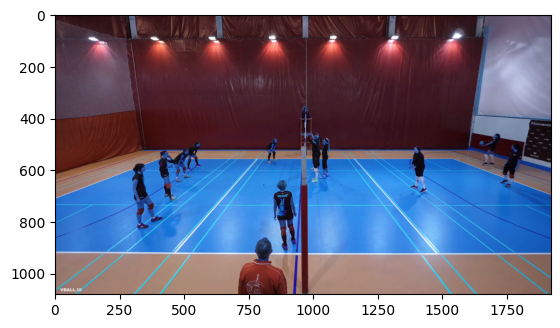

In [13]:
ret,frame = cap.read()

plt.imshow(frame)

frame = cv2.resize(frame, (1300, 500))

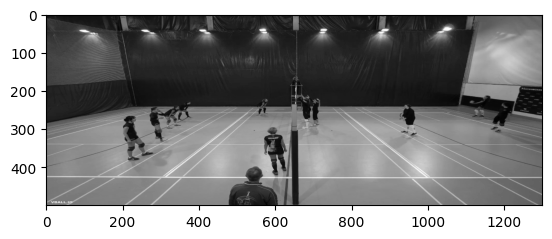

In [14]:
# convert the current frame to grayscale
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# equalize historgram of the grayscale frame
curr_gray = cv2.equalizeHist(gray)

# stabilization step
stabilized_frame = stabilize(frame, prev_gray, curr_gray, warp_matrix, warp_mode, termination_criteria)
stabilized_gray = cv2.cvtColor(stabilized_frame, cv2.COLOR_BGR2GRAY)

plt.imshow(stabilized_gray, cmap='gray')
#print(stabilized_frame)

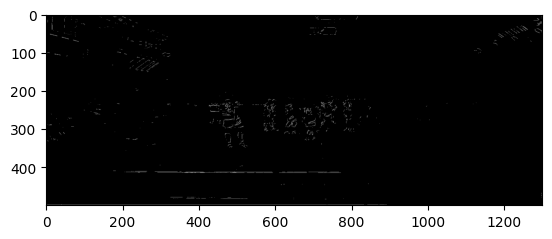

In [11]:
fgmask = subtract_background(stabilized_frame, fgbg)
plt.imshow(fgmask, cmap='gray')

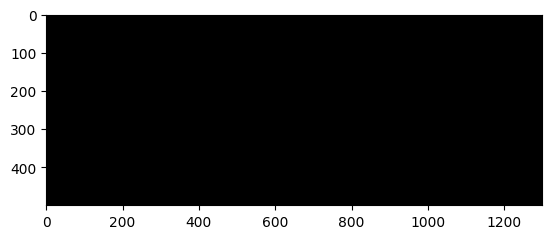

In [12]:
fgmask = morphological_segmentation(fgmask, kernel)
plt.imshow(fgmask, cmap='gray')

In [9]:
while True :
    ret,frame = cap.read()
    
    
    if not ret:
        break
        
    frame = cv2.resize(frame,(1300,500))
    
    # convert the current frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
    # equalize historgram of the grayscale frame
    curr_gray = cv2.equalizeHist(gray)

    # stabilization step
    stabilized_frame = stabilize(frame, prev_gray, curr_gray, warp_matrix, warp_mode, termination_criteria)
    
    # background subtraction step
    fgmask = subtract_background(stabilized_frame, fgbg)
    
    #morphological segmentation step
    fgmask = morphological_segmentation(fgmask, kernel)
    
    #cv2.imshow('foreground mask',fgmask)

    # Find contours in the foreground mask
    contours, _ = cv2.findContours(fgmask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    # possible candidate ball
    candidate_ball = None
    
    prev_gray = curr_gray
    
    
    for contour in contours:
            
        #apply circularity filter
        if circularity_filter(contour):
            candidate_ball =  contour
                
        #apply eccentricity filter
        elif eccentricity_filter(contour):
            candidate_ball = contour
            
        # filter out blobs which are either too big or too small
        if size_filter(contour, 20,60):
            candidate_ball = None
        
   
    if candidate_ball is not None: 
        
        # get the minimum enclosing circle for the candidate object
        (x, y), radius = cv2.minEnclosingCircle(candidate_ball)
        
        ball_pos.append(np.array([[x], [y]]))
        
        # draw green circle around the predicted ball
        cv2.circle(frame, (int(x),int(y)), int(radius), (0,255,0), 2)

    cv2.imshow('frame',frame)  
    
    if cv2.waitKey(10) == ord("q"): 
        break
    

cap.release()
cv2.destroyAllWindows()

# Trajectoire 2D

In [10]:
from plot_utils import plot_trajectories, plot_trajectories_kalman

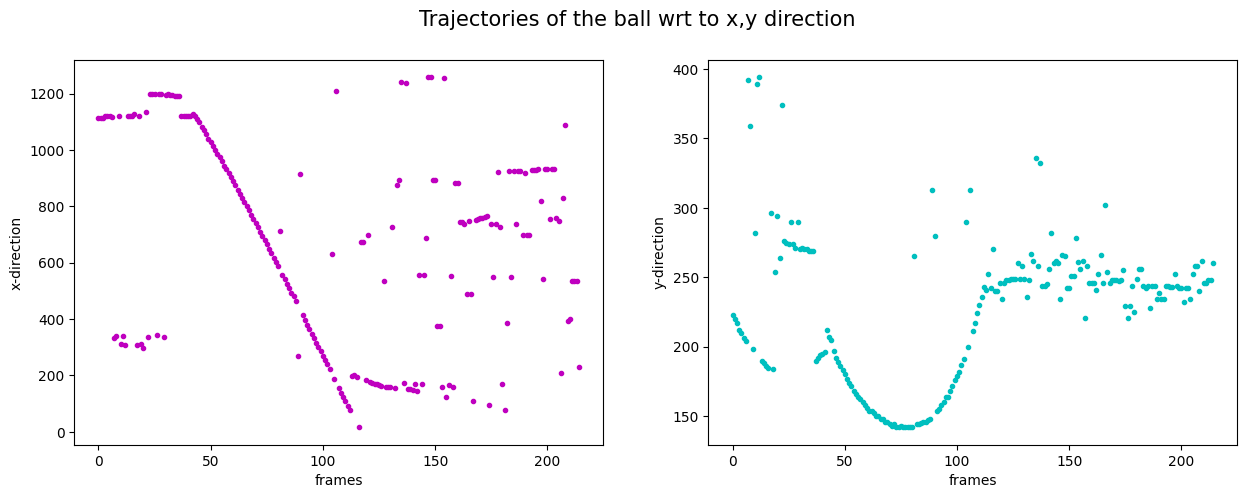

In [11]:

# array of rounded x coordinates of the detected ball
x_coord = np.array([round(ball_pos[i][0][0]) for i in range(len(ball_pos))])

# array of rounded y coordinates of the detected ball
y_coord = np.array([round(ball_pos[i][1][0]) for i in range(len(ball_pos))])

# plot trajectories wrt x and y direction
plot_trajectories(x_coord, y_coord)

In [41]:
from kalman_filter import KalmanFilter

In [42]:
# use Kalman filter to keep tracking of the ball even when it disappears

# initialize the Kalman filter
kfilter = KalmanFilter(0.1, 1, 1, 1, 0.1,0.1)

# list to store the updates
updates = []

for i in range(len(ball_pos)):
    
    # get the 2d position of the blob in current frame
    measure = ball_pos[i]

    # prediction step
    (x, y) = kfilter.predict()

    # optimisation step
    (x1, y1) = kfilter.optimize(measure)
    
    updates.append([np.array(x1)[0][0],np.array(y1)[0][0]])

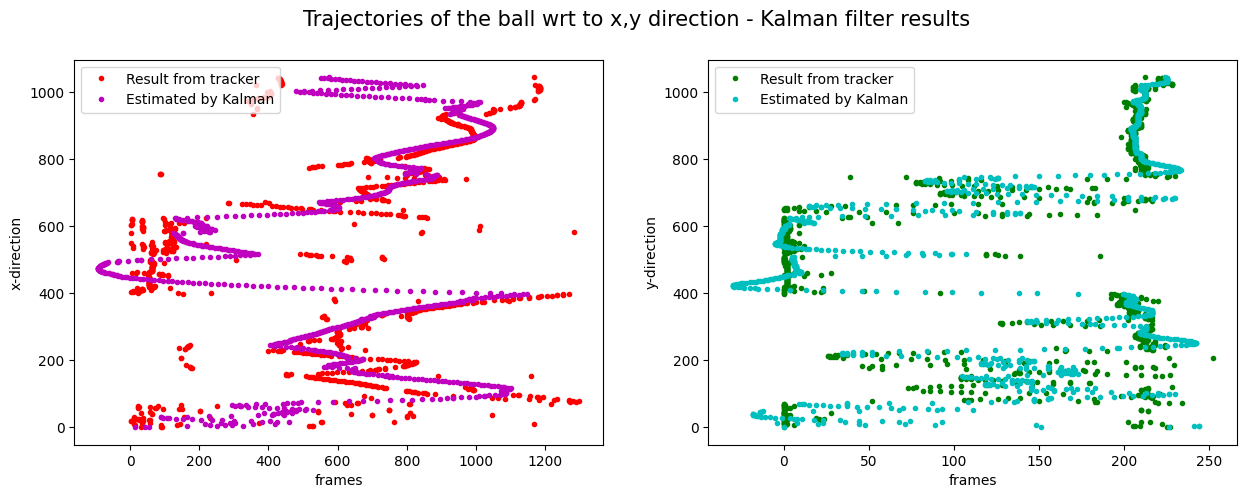

In [43]:
# the predicted x and y positions
tracked_pos = np.array(updates)

plot_trajectories_kalman(x_coord, y_coord, tracked_pos)

# Approche par flot optique - algorithme de Lucas-Kanade

In [1]:
import cv2
from utils import stabilize, subtract_background, morphological_segmentation, circularity_filter, eccentricity_filter, size_filter, optic_flow_scores, mean_y_pos, mean_contour, get_mask_color
import matplotlib.pyplot as plt
import numpy as np
VIDEOS_DIR = './videos'

In [13]:
VIDEO_FOLDER = '../data/CDF M17 VBALL - Voiron/'
#VIDEO_NAME = 'Vb@ll - Voiron 1er Set 25-21.mkv'
VIDEO_NAME = 'points_cut.mp4'

cap = cv2.VideoCapture(VIDEOS_DIR + '/rally1.mp4')

In [14]:
# get first frame
ret, prev = cap.read()

# convert frame to grayscale
prev_gray = cv2.resize(cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY),(1300,500))

# create an ellipsoidal structuring element with a size of (5, 5)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)) 

# create a MOG2 background subrtractor
fgbg =cv2.createBackgroundSubtractorMOG2() 

# define the motion model
warp_mode = cv2.MOTION_HOMOGRAPHY
 
# termination criteria for the optical flow algorithm
termination_criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1e-3)

# initialize warp matrix
cc, warp_matrix = None,None

# list to store ball positions
ball_pos = []

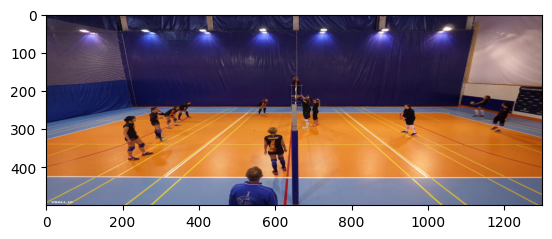

In [15]:
prev_rgb = cv2.cvtColor(cv2.resize(prev,(1300,500)), cv2.COLOR_BGR2RGB)
plt.imshow(prev_rgb)

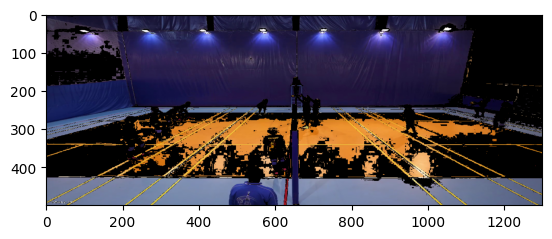

In [16]:
current_hsv = cv2.cvtColor(cv2.resize(prev,(1300,500)), cv2.COLOR_BGR2HSV)
mask_ball_color = get_mask_color(current_hsv)
plt.imshow(cv2.bitwise_and(prev_rgb, prev_rgb, mask = mask_ball_color*255))

In [17]:
ret,current_frame = cap.read()
current_frame = cv2.resize(current_frame, (1300, 500))
current_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
current_gray = cv2.equalizeHist(current_gray)
current_stabilized = stabilize(current_frame, prev_gray, current_gray, warp_matrix, warp_mode, termination_criteria)
current_fgmask = subtract_background(current_stabilized, fgbg)
current_fgmask = morphological_segmentation(current_fgmask, kernel)

while True :
    next_ret, next_frame = cap.read()
    
    if not ret and next_ret:
        break
        
    next_frame = cv2.resize(next_frame,(1300,500))
    
    # convert the current frame to grayscale
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
        
    # equalize historgram of the grayscale frame
    next_gray = cv2.equalizeHist(next_gray)

    # stabilization step
    next_stabilized = stabilize(next_frame, current_gray, next_gray, warp_matrix, warp_mode, termination_criteria)
    
    # background subtraction step
    next_fgmask = subtract_background(next_stabilized, fgbg)
    
    #morphological segmentation step
    next_fgmask = morphological_segmentation(next_fgmask, kernel)
    
    #cv2.imshow('foreground mask',fgmask)

    # Find contours in the foreground mask
    # Those are the keypoints used for Lucas-Kanade
    contours, _ = cv2.findContours(current_fgmask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    current_hsv = cv2.cvtColor(current_frame, cv2.COLOR_BGR2HSV)
    mask_ball_color = get_mask_color(current_hsv)
    cv2.bitwise_and(current_hsv,current_hsv,mask = mask_ball_color*255)
    # possible candidate ball
    best_candidate_ball = None
    
    contours_scores = []
    base_score = 0    
    
    for contour in contours:
        
        # Idea : give each contour a score indicating the probability of it being the ball
        contour_score = base_score
            
        #apply circularity filter
        if circularity_filter(contour):
            contour_score += 300
                
        #apply eccentricity filter
        if eccentricity_filter(contour):
            contour_score += 100
        
        # take into account y position (the ball is supposed to be on the top of the frame in most cases)
        # contour_score += mean_y_pos(contour)/10
        # this approach gives worst results for now
        # filter out blobs which are either too big or too small
        if size_filter(contour, 30,60):
            contour_score = 0
        # filter on the color of the ball but does not work well
        elif mean_contour(mask_ball_color, contour)<0.2:
            contour_score = 0
        
        
        contours_scores.append(contour_score)
        
        base_score += 1
        
    
    # trier preselected contours pour qu'il apparaissent par ordre décroissant de score
    sorted_scores_and_index = sorted(zip(contours_scores,range(len(contours))), reverse=True)
    sorted_index = [index for _, index in sorted_scores_and_index]
    sorted_contours = [contours[index] for index in sorted_index]
    sorted_scores = [score for score,_ in sorted_scores_and_index]
    # trouver le point d'arrêt à partir duquel on ne sélectionne plus les contours
    # ce sera le minimum entre 50 et l'index à partir duquel le score du contour est nul
    termination_index = min(10, len(sorted_contours))
    try:
        null_index = min(sorted_scores.index(0), termination_index)
    except ValueError as err:
        None
    
    preselected_contours = sorted_contours[:termination_index]
    # apply lucas kanade method to compute optic flow
    of_scores = optic_flow_scores(preselected_contours, current_fgmask, next_fgmask)
    
    #if of_scores:
        #print(min(of_scores), max(of_scores))
        
    for index in range(termination_index):
        contours_scores[sorted_index[index]] += of_scores[index]
    
    current_gray = next_gray
    current_fgmask = next_fgmask
    
    #if preselected_contours:
    #    # search for a criteria to decide the best: we take the one that has the highest optic flow vector norm
    #    best_of_index = of_scores.index(max(of_scores))
    #    best_candidate_ball = contours[best_of_index]
    
    # old approach choosing the best contour score in the end. Now the score is just a way to choose the best preselected.
    # though it can be used to enhance the score instead of being the decision criteria alone
    if contours:    
        best_contour_index = contours_scores.index(max(contours_scores))
        best_candidate_ball = contours[best_contour_index]
   
    if best_candidate_ball is not None: 
        # get the minimum enclosing circle for the candidate object
        (x, y), radius = cv2.minEnclosingCircle(best_candidate_ball)
        
        ball_pos.append(np.array([[x], [y]]))
        
        # draw green circle around the predicted ball
        cv2.circle(current_frame, (int(x),int(y)), int(radius), (0,255,0), 2)

    cv2.imshow('frame',current_frame) 
    
    current_frame = next_frame
    
    if cv2.waitKey(10) == ord("q"): 
        break
    
    
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.7.0-dev) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [ ]:
contour = contours[0]

In [24]:
contour[0]

array([[517, 327]], dtype=int32)

In [26]:
contour[0,0,1]

327